In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(10,8)})
#pd.options.display.max_rows = 100

In [53]:
# Loading the csv file to a dataframe
loans_original_df = pd.read_csv("loan.csv")

# we get a warning regarding the dtype, it didnt seem intuitive to set Dtypes for the columns induvidually as its very tedious
# Also set low_memory=False is not used since its depricated. Ref: https://github.com/pandas-dev/pandas/issues/5888

C:\Users\ADAMIN\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [54]:
# Removing rows and columns having all NA values.
loan_df = loans_original_df.dropna(axis = 0, how = 'all')
loan_df = loans_original_df.dropna(axis = 1, how = 'all')

In [55]:
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 57 columns):
id                            39717 non-null int64
member_id                     39717 non-null int64
loan_amnt                     39717 non-null int64
funded_amnt                   39717 non-null int64
funded_amnt_inv               39717 non-null float64
term                          39717 non-null object
int_rate                      39717 non-null object
installment                   39717 non-null float64
grade                         39717 non-null object
sub_grade                     39717 non-null object
emp_title                     37258 non-null object
emp_length                    38642 non-null object
home_ownership                39717 non-null object
annual_inc                    39717 non-null float64
verification_status           39717 non-null object
issue_d                       39717 non-null object
loan_status                   39717 non-null object
pymnt_pl

In [56]:
def get_percentages_co_fp(col):
    '''
    This function takes in the column name from the main dataframe, groups by loan status and the column name
    and gives the percentage division of charged off Vs Fully paid. 
    '''
    temp_df = loan_df.groupby([col,'loan_status'])['loan_amnt'].agg('count')
    temp_df_percent = temp_df.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
    return temp_df_percent

In [57]:
def draw_ratio_graph(dataset, first_param, second_param='loan_status'):
    '''
    This function takes in the column name from the main dataframe, groups by loan status and the column name
    and gives the graph based on the percentage division of charged off Vs Fully paid. 
    '''
    second_param = dataset[second_param]
    dataset_grp = dataset.groupby([first_param, second_param])
    df_new = dataset_grp.size().unstack()
    #print(df_new)
    df_new = df_new.fillna(0)
    df_new['default_ratio'] = df_new.apply(lambda x:  100 * x['Charged Off']/x.sum(), axis=1)
    print(df_new)
    df_final = df_new.drop(columns=["Charged Off", "Fully Paid"])
    df_final.plot(kind="bar", stacked=True, figsize=[16,6], colormap='winter',title="default ratio")

In [58]:
# Since we need to assess the driving patterns behind loan defaults, the current loans would not provide any insights
# into our analysis, so dropping all rows with Loan status = Current
loan_df = loan_df[loan_df.loan_status != 'Current']

In [59]:
# We see that the columns mths_since_last_record, next_pymnt_d has more than 95% missing data so dropping these columns
# Also the column mths_since_last_delinq has more than 50% data missing so dropping this column as well.
loan_df = loan_df.drop(['mths_since_last_record','next_pymnt_d','mths_since_last_delinq'], axis = 1)

In [60]:
# Dropping columns whose values do not influence the results.
loan_df = loan_df.drop(['desc', 'emp_title', 'id', 'member_id', 'title', 'url', 'zip_code'], axis=1)

In [61]:
#Finding the columns that have only one single value in them, this would not aid in our analysis
loan_df.loc[:,loan_df.apply(pd.Series.nunique) == 1].columns

Index(['pymnt_plan', 'initial_list_status', 'out_prncp', 'out_prncp_inv',
       'collections_12_mths_ex_med', 'policy_code', 'application_type',
       'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt',
       'tax_liens'],
      dtype='object')

In [62]:
# Dropping the columns above
loan_df = loan_df.drop(['pymnt_plan', 'initial_list_status', 'out_prncp', 'out_prncp_inv','collections_12_mths_ex_med', 'policy_code', 'application_type','acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt','tax_liens'], axis=1)

In [63]:
# COnverting interest rates to float
loan_df['int_rate'] = loan_df['int_rate'].apply(lambda x: x.replace('%','')).astype('float64')

[None]

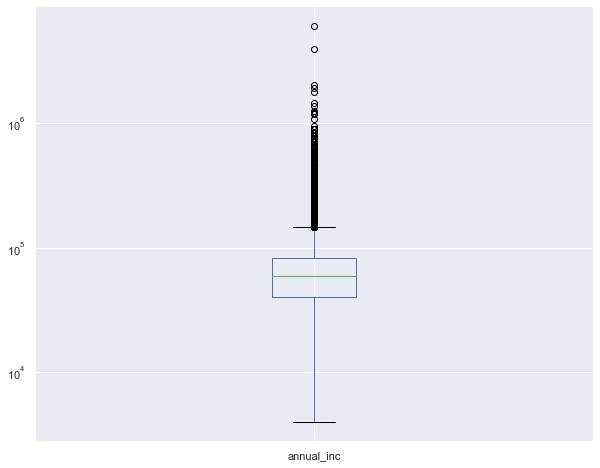

In [64]:
# We see there a lot of outliers for the column annual_inc, this needs cleanup for analysis
ax = loan_df.boxplot(column='annual_inc', return_type='axes')
ax.set(yscale="log")

In [65]:
upper = np.percentile(loan_df.annual_inc,95)
lower = np.percentile(loan_df.annual_inc,5)
loan_df = loan_df.loc[(loan_df.annual_inc >= lower) & (loan_df.annual_inc <= upper)]

loan_status  Charged Off  Fully Paid  default_ratio
emp_length                                         
1 year               412        2434      14.476458
10+ years           1252        6539      16.069824
2 years              501        3320      13.111751
3 years              500        3145      13.717421
4 years              419        2637      13.710733
5 years              419        2528      14.217849
6 years              284        1730      14.101291
7 years              246        1366      15.260546
8 years              189        1130      14.329037
9 years              146         986      12.897527
< 1 year             529        3367      13.578029


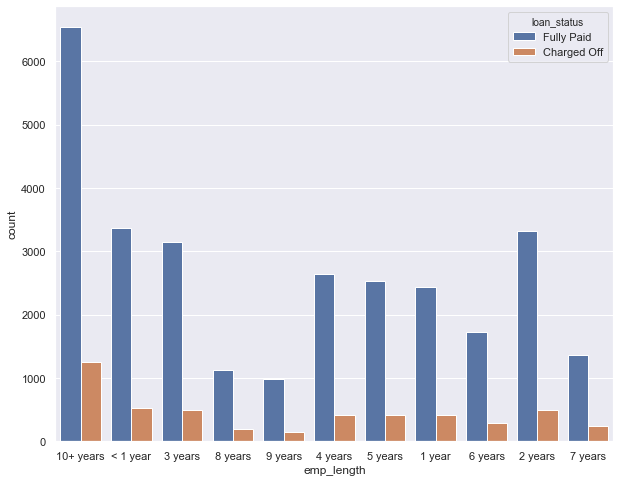

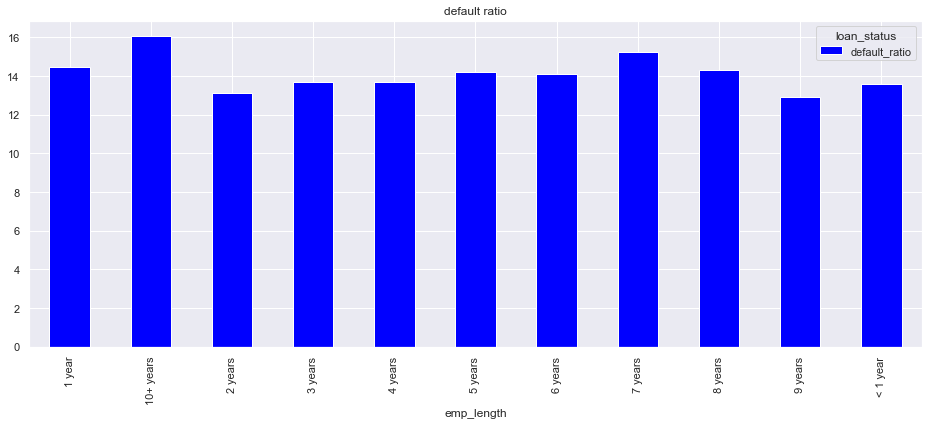

In [66]:
# Plotting emplyment length for fully paid and charged off loans
# There doesnt seem to be much difference with the employment length vs the tendency to default on loans
# We can see that from the graph and data below that for employemmnt length the default percentage of loans varies from 13%-15% and is quite inconsistent
# Looks like the employment length doesnt have impact on loan defaulting by itself
ax = sns.countplot(x=loan_df.emp_length, hue = loan_df.loan_status ,data=loan_df)
draw_ratio_graph(loan_df, loan_df['emp_length'])

# Impact of  emp_length on default:

Plotting employment length for fully paid and charged off loans
There doesnt seem to be much difference with the employment length vs the tendency to default on loans
We can see that from the graph and data below that for employemmnt length the default percentage of loans varies from 13%-15% and is quite inconsistent
Looks like the employment length doesnt have impact on loan defaulting by itself

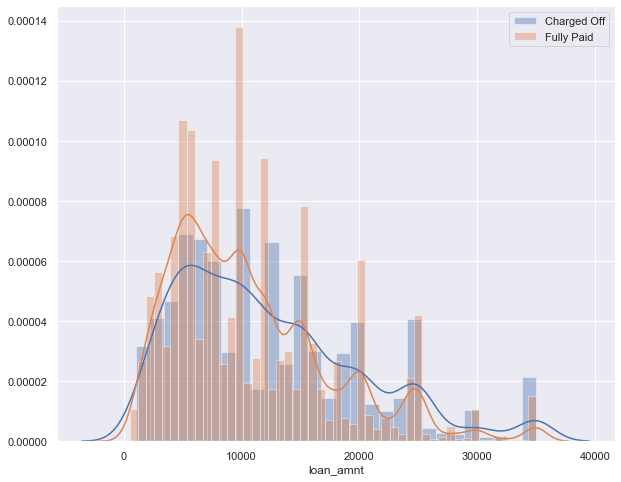

In [67]:
# Looking at the distribution of loan amount for charged off and fully paid loans
# We can see that after $15000, the tendency to defult is higher than paying off

df_co = loan_df[loan_df.loan_status == 'Charged Off']
df_fp = loan_df[loan_df.loan_status == 'Fully Paid']

sns.distplot(df_co.iloc[:,0],  kde=True, label='Default loans')
sns.distplot(df_fp.iloc[:,0],  kde=True, label='Paid loans')

plt.legend(labels=['Charged Off','Fully Paid'])
plt.show()

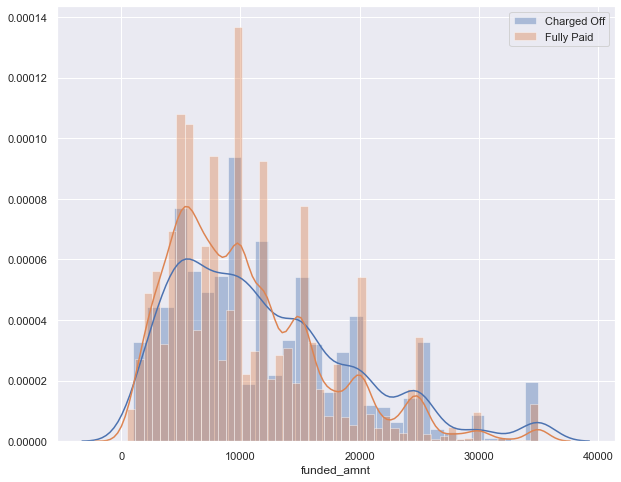

In [68]:
# Funded amount also has the same distribution as loan amount which is expected

df_co = loan_df[loan_df.loan_status == 'Charged Off']
df_fp = loan_df[loan_df.loan_status == 'Fully Paid']

sns.distplot(df_co.iloc[:,1],  kde=True, label='Default loans')
sns.distplot(df_fp.iloc[:,1],  kde=True, label='Paid loans')

plt.legend(labels=['Charged Off','Fully Paid'])
plt.show()

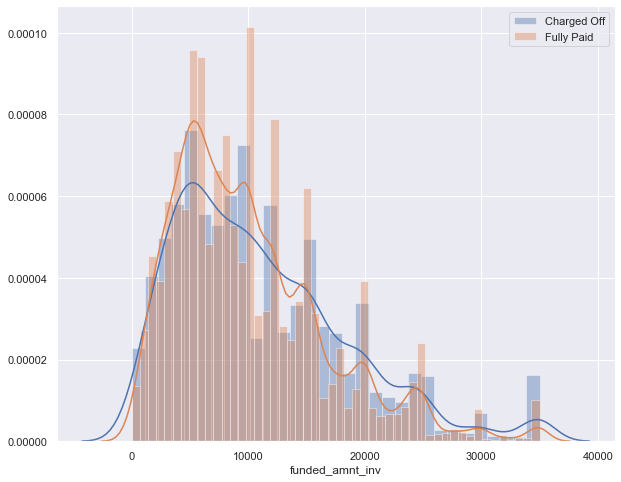

In [69]:
# Funded_amt_inv also has the sane distribution as loan amount which is expected
# These three seem to be highly correlated, which can be found out using the scatter plot

df_co = loan_df[loan_df.loan_status == 'Charged Off']
df_fp = loan_df[loan_df.loan_status == 'Fully Paid']

sns.distplot(df_co.iloc[:,2],  kde=True, label='Default loans')
sns.distplot(df_fp.iloc[:,2],  kde=True, label='Paid loans')

plt.legend(labels=['Charged Off','Fully Paid'])
plt.show()

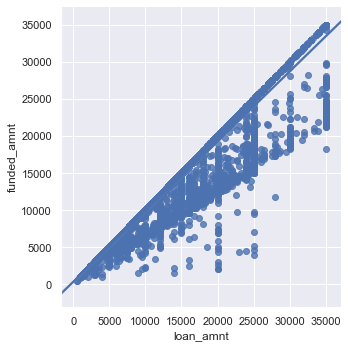

In [70]:
# There seem to be many outliers but we are not considering these columns for further analysis
sns.lmplot('loan_amnt','funded_amnt',data=loan_df)

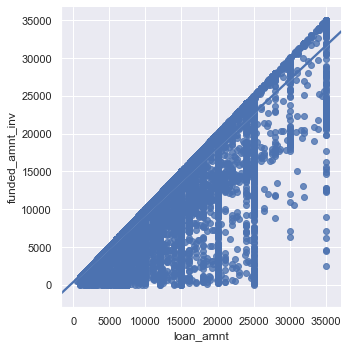

In [71]:
# There seem to be many outliers but we are not considering these columns for further analysis
sns.lmplot('loan_amnt','funded_amnt_inv',data=loan_df)

# Impact of  'loan_amnt/funded_amnt_inv/funded_amnt' on default:

We can see that after $15000, the tendency to default is higher than paying off

loan_status  Charged Off  Fully Paid  default_ratio
term                                               
 36 months          2843       23324      10.864830
 60 months          2221        6481      25.522868


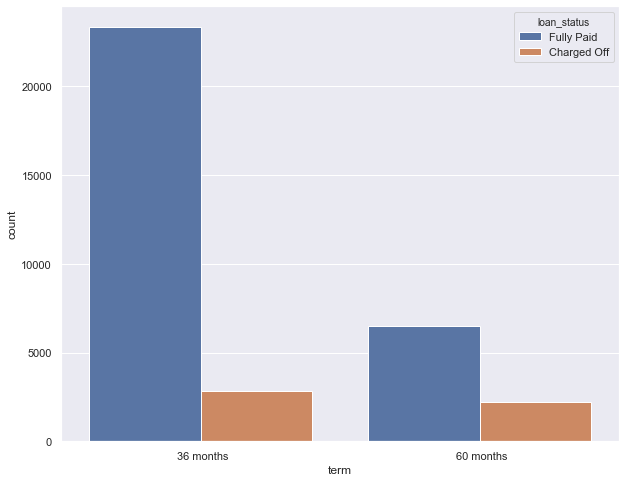

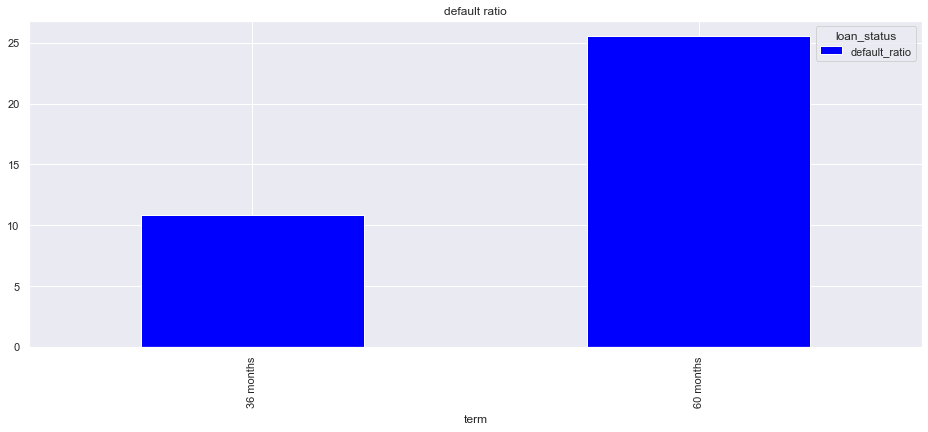

In [72]:
# Plotting the term of loan for charged off and fully paid loan
# We can clearly see that the percentage of charged off loan for 60 months term is significanntly higher

ax = sns.countplot(x=loan_df.term, hue = loan_df.loan_status ,data=loan_df)
draw_ratio_graph(loan_df, loan_df['term'])

# Impact of 'term' on default

Finding the percentages of charged off vs Fully paid loans for the above
For a term of 36 Months, 11% of the loans are charged off
For a term of 60 Months, over 25% of the loans are charged off
So, it is more probable that a person will default if the term is 60 months.

loan_status       Charged Off  Fully Paid  default_ratio
int_rate_rounded                                        
5.0                        18         516       3.370787
6.0                        48        1362       3.404255
7.0                       167        2813       5.604027
8.0                       209        2863       6.803385
9.0                       107        1244       7.920059
10.0                      325        2747      10.579427
11.0                      550        3929      12.279527
12.0                      427        2385      15.184922
13.0                      665        3508      15.935778
14.0                      446        2097      17.538341
15.0                      441        1835      19.376098
16.0                      514        1858      21.669477
17.0                      331         932      26.207443
18.0                      265         713      27.096115
19.0                      219         482      31.241084
20.0                      143  

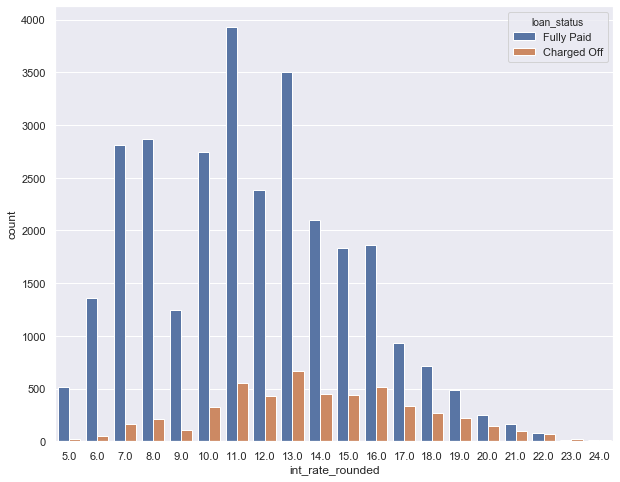

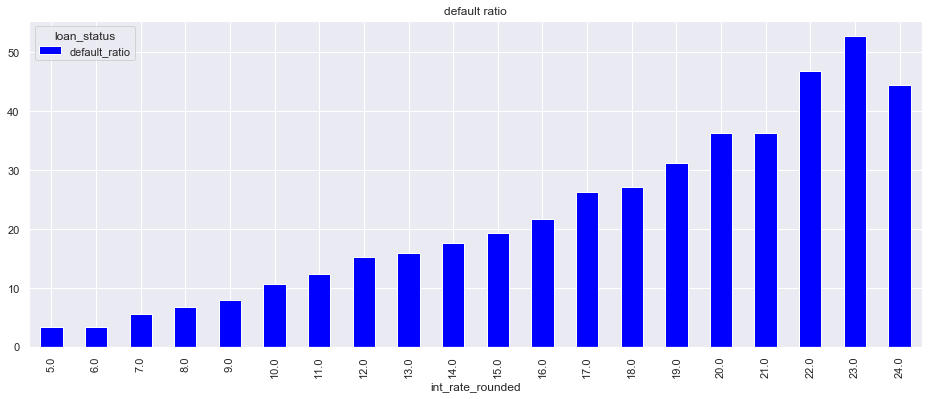

In [73]:
loan_df['int_rate_rounded'] = loan_df.int_rate.round(0)
ax = sns.countplot(x=loan_df.int_rate_rounded, hue = loan_df.loan_status ,data=loan_df)
draw_ratio_graph(loan_df, loan_df['int_rate_rounded'])

# Impact of loan_rate on default

We see that more the interest, more is the probablity of default.
23% and 24% rates have very less samples, this could be ignored.
Interest rate 16% has crossed the default rate of 20%.
We can say that 15% onwards, the default chances are significant.

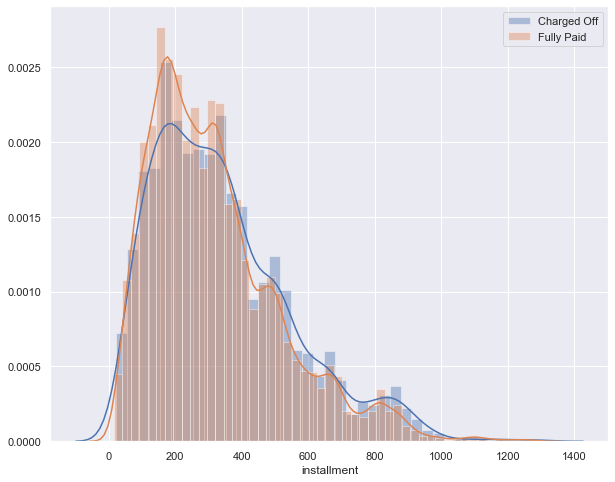

In [74]:
# The installment amount does not show any significant indication that loans will be charged off
# This plot is similar to the loan_amnt, since they are related
sns.distplot(df_co.installment, label='Default loans')
sns.distplot(df_fp.installment, label='Paid loans')
plt.legend(labels=['Charged Off','Fully Paid'])
plt.show()

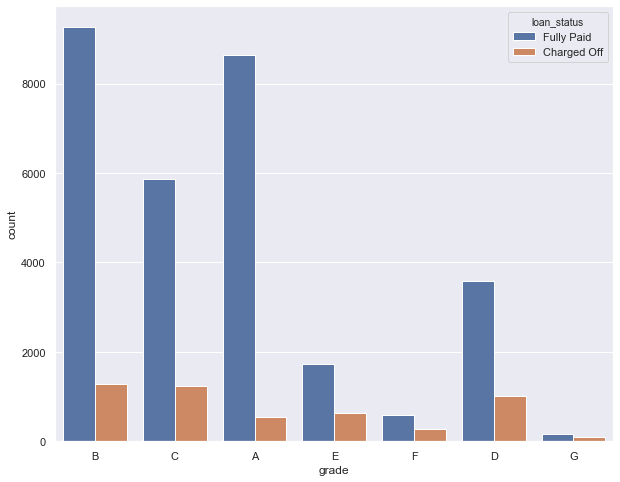

In [75]:
# Plotting grades for the fully paid and charged off loans
ax = sns.countplot(x=loan_df.grade, hue = loan_df.loan_status ,data=loan_df)


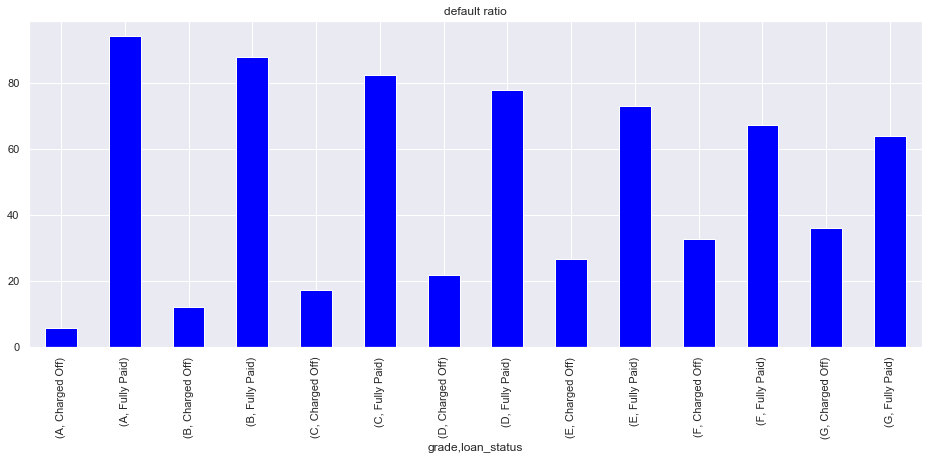

In [76]:
df = get_percentages_co_fp('grade')
df.plot(kind="bar", stacked=True, figsize=[16,6], colormap='winter',title="default ratio")

#We can clearly see that as the loan grades increase from A to G, the percentage of loans charged off consistently go up

# Impact of 'grade' on default
We can clearly see that as the loan grades increase from A to G, the percentage of loans charged off consistently go up
We see that grade A and B are fairly safer than others

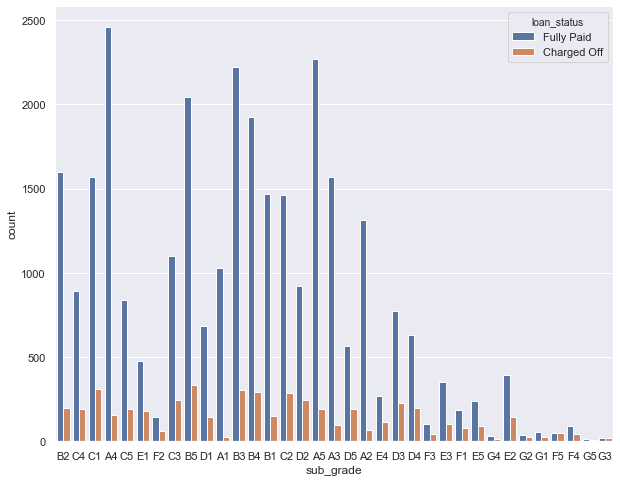

In [77]:
# Within subgrades there is inconsistent vairation
# Could be due to various factors considered to provide these grading
ax = sns.countplot(x=loan_df.sub_grade, hue = loan_df.loan_status ,data=loan_df)

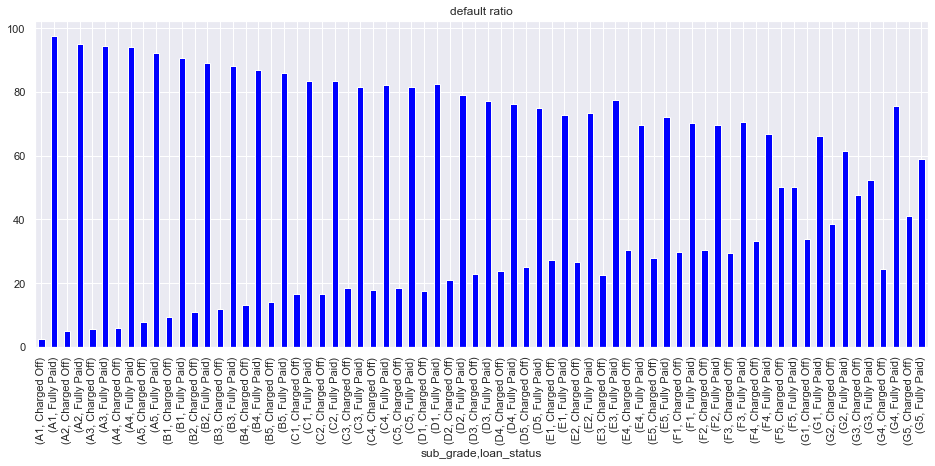

In [78]:
df = get_percentages_co_fp('sub_grade')
df.plot(kind="bar", stacked=True, figsize=[16,6], colormap='winter',title="default ratio")


# Impact of 'subgrade' on default

A1 to B5 - We see a consistent inscrease in the percent of charged off loans
From D2, the default percent touched 20%
From C subgrade, the default percentage is higher than 15
F1 to G5 is incosistent as well but the samples are too less to conclude

loan_status     Charged Off  Fully Paid  default_ratio
home_ownership                                        
MORTGAGE             2161.0     13346.0      13.935642
NONE                    0.0         2.0       0.000000
OTHER                  17.0        71.0      19.318182
OWN                   381.0      2174.0      14.911937
RENT                 2505.0     14212.0      14.984746


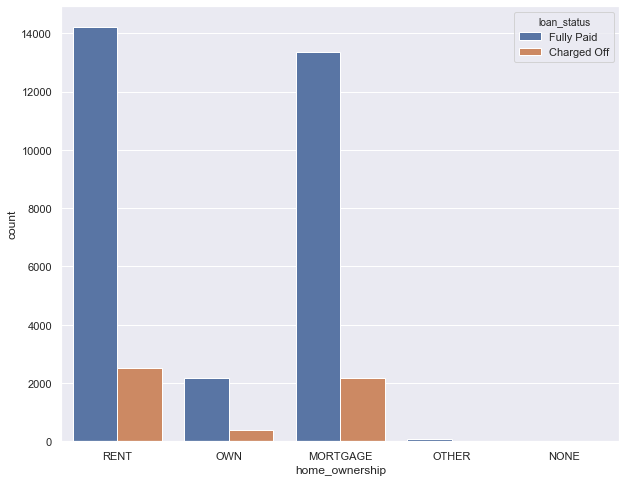

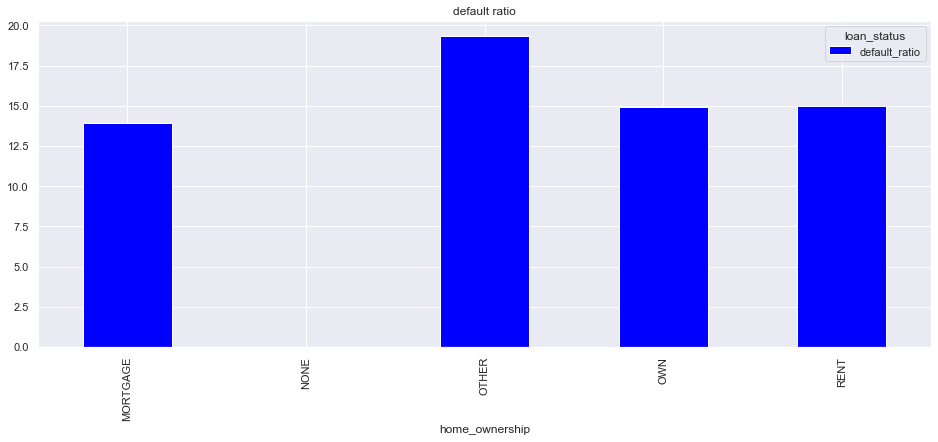

In [79]:
ax = sns.countplot(x=loan_df.home_ownership, hue = loan_df.loan_status ,data=loan_df)
draw_ratio_graph(loan_df, loan_df['home_ownership'])

# Impact of 'home_ownership' on default

We see that although 'OTHERS' have 18% chances of defaulting on loan the data available is not too much 
And with mortgage, own and rent the percentages vary slightly
If we need choose a categroy then rented people will chances of defaulting more

In [80]:

df_co = loan_df[loan_df.loan_status == 'Charged Off']
df_fp = loan_df[loan_df.loan_status == 'Fully Paid']


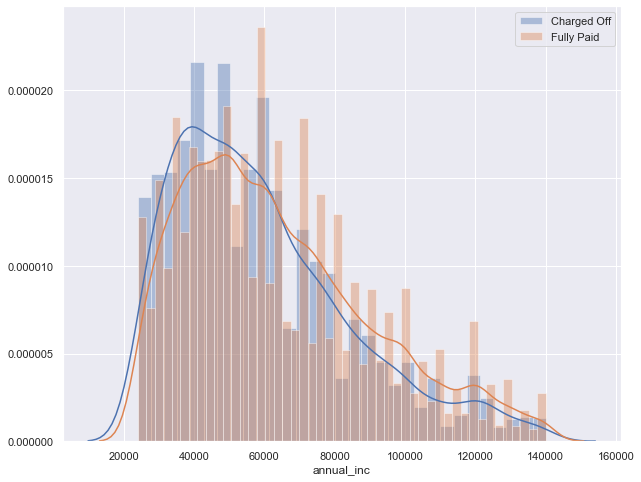

In [81]:
# Here we see that loans getting charged off is consistently higher than loans getting fully paid in the lower income category
# Until around $65000 after which the chances of loans getting fully paid is higher than them being charged off
# Also the number of people taking loans in the higher income bracket is lower which is expected
co_annual = loan_df.loc[loan_df.loan_status == 'Charged Off']
fp_annual = loan_df.loc[loan_df.loan_status == 'Fully Paid']
sns.distplot(co_annual.annual_inc, label='Default loans')
sns.distplot(fp_annual.annual_inc, label='Paid loans')
plt.legend(labels=['Charged Off','Fully Paid'])
plt.show()

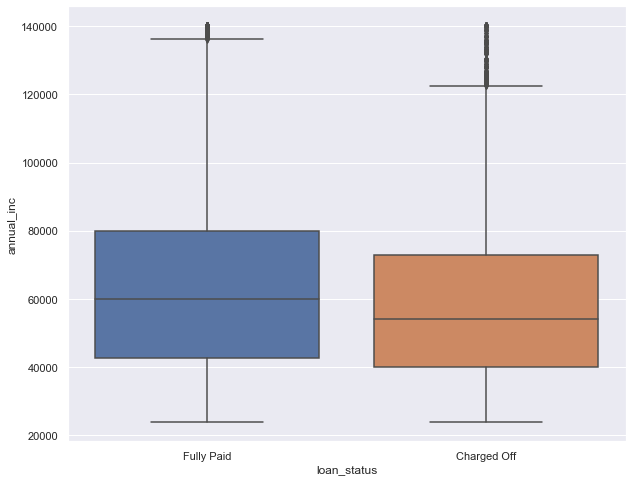

In [82]:
sns.boxplot(x='loan_status', y='annual_inc', data=loan_df)
plt.show()

# Inference of 'annual_inc' on default

The annual salary between 40000 to 100000 are more prone to default with default percentage above 15%

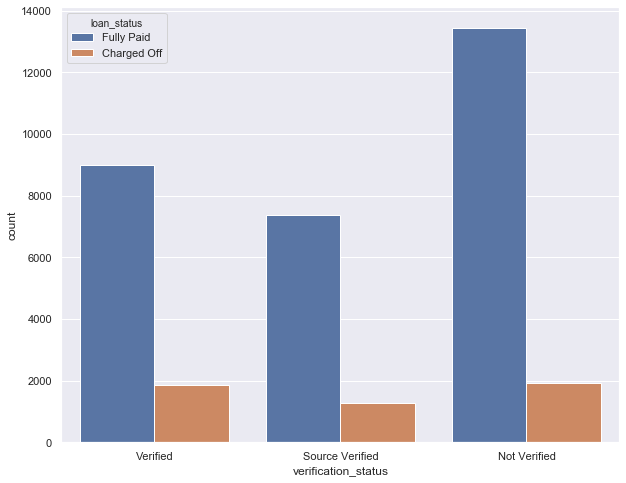

In [83]:

ax = sns.countplot(x=loan_df.verification_status, hue = loan_df.loan_status ,data=loan_df)

In [84]:
get_percentages_co_fp('verification_status')

verification_status  loan_status
Not Verified         Charged Off    12.495117
                     Fully Paid     87.504883
Source Verified      Charged Off    14.825078
                     Fully Paid     85.174922
Verified             Charged Off    17.152074
                     Fully Paid     82.847926
Name: loan_amnt, dtype: float64

# Impact of 'verification_status' on default

We see that loans with Non verified sources has the lesser percentage of being charged off than verified sources
This needs looking into as it seems quite non intuitive
Probable reason could be that loans that have a higher change of being charged off are looked into and rest are not verified
Hence the verified ones tend to default as they have higher risk

[Text(0, 0, 'credit_card'),
 Text(0, 0, 'car'),
 Text(0, 0, 'other'),
 Text(0, 0, 'wedding'),
 Text(0, 0, 'debt_consolidation'),
 Text(0, 0, 'small_business'),
 Text(0, 0, 'home_improvement'),
 Text(0, 0, 'major_purchase'),
 Text(0, 0, 'medical'),
 Text(0, 0, 'moving'),
 Text(0, 0, 'vacation'),
 Text(0, 0, 'house'),
 Text(0, 0, 'renewable_energy'),
 Text(0, 0, 'educational')]

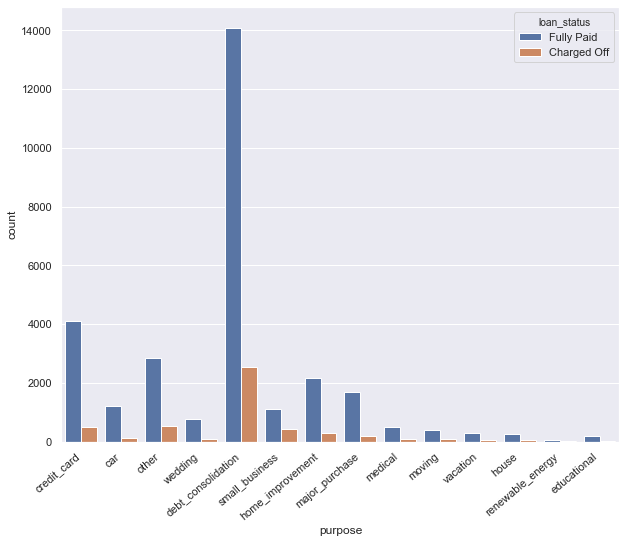

In [85]:

ax = sns.countplot(x=loan_df.purpose, hue = loan_df.loan_status ,data=loan_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

loan_status         Charged Off  Fully Paid  default_ratio
purpose                                                   
car                         145        1202      10.764662
credit_card                 503        4125      10.868626
debt_consolidation         2538       14089      15.264329
educational                  42         207      16.867470
home_improvement            311        2183      12.469928
house                        53         273      16.257669
major_purchase              190        1704      10.031679
medical                      95         513      15.625000
moving                       78         406      16.115702
other                       526        2847      15.594426
renewable_energy             15          67      18.292683
small_business              434        1122      27.892031
vacation                     46         290      13.690476
wedding                      88         777      10.173410


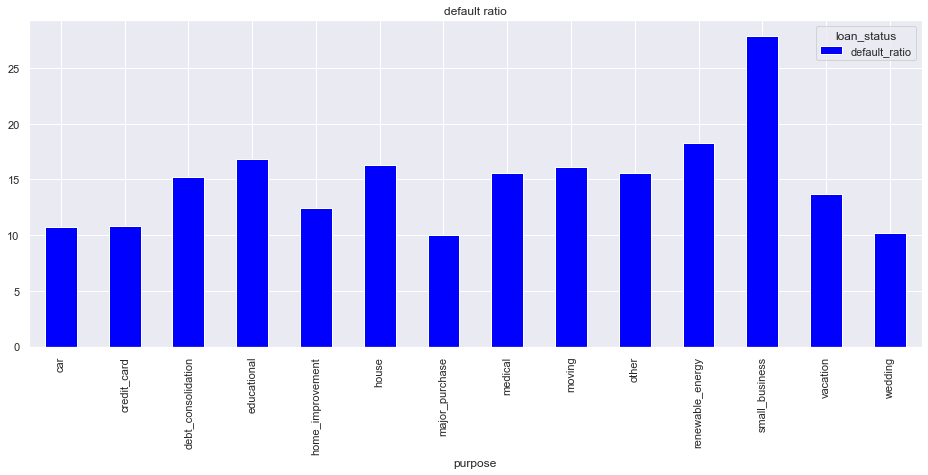

In [86]:
draw_ratio_graph(loan_df, loan_df['purpose'])

# Impact of 'purpose' on default:

We see that Small Businesses have a considerable pecentage of charged off loans compared to others at 27% 
Followed by Renewable energy at 18.6% and Educational at 17.2%

In [87]:
# Converting states into regions
# Python dictionary mapping two letter state abbreviations to their respective regions of the country (i.e. Midwest, North East, etc.) N - North East W - West M - Mid West S - South O - Other
# Source - http://code.activestate.com/recipes/580661-states-to-regions/
# We see that others have the highest charged off percentage of loans at 17.6% followed by west at 15.8%

states = {
        'AK': 'O',
        'AL': 'S',
        'AR': 'S',
        'AS': 'O',
        'AZ': 'W',
        'CA': 'W',
        'CO': 'W',
        'CT': 'N',
        'DC': 'N',
        'DE': 'N',
        'FL': 'S',
        'GA': 'S',
        'GU': 'O',
        'HI': 'O',
        'IA': 'M',
        'ID': 'W',
        'IL': 'M',
        'IN': 'M',
        'KS': 'M',
        'KY': 'S',
        'LA': 'S',
        'MA': 'N',
        'MD': 'N',
        'ME': 'N',
        'MI': 'W',
        'MN': 'M',
        'MO': 'M',
        'MP': 'O',
        'MS': 'S',
        'MT': 'W',
        'NA': 'O',
        'NC': 'S',
        'ND': 'M',
        'NE': 'W',
        'NH': 'N',
        'NJ': 'N',
        'NM': 'W',
        'NV': 'W',
        'NY': 'N',
        'OH': 'M',
        'OK': 'S',
        'OR': 'W',
        'PA': 'N',
        'PR': 'O',
        'RI': 'N',
        'SC': 'S',
        'SD': 'M',
        'TN': 'S',
        'TX': 'S',
        'UT': 'W',
        'VA': 'S',
        'VI': 'O',
        'VT': 'N',
        'WA': 'W',
        'WI': 'M',
        'WV': 'S',
        'WY': 'W'
}
loan_df['region'] = loan_df['addr_state'].map(states)


[Text(0, 0, 'W'),
 Text(0, 0, 'S'),
 Text(0, 0, 'M'),
 Text(0, 0, 'N'),
 Text(0, 0, 'O')]

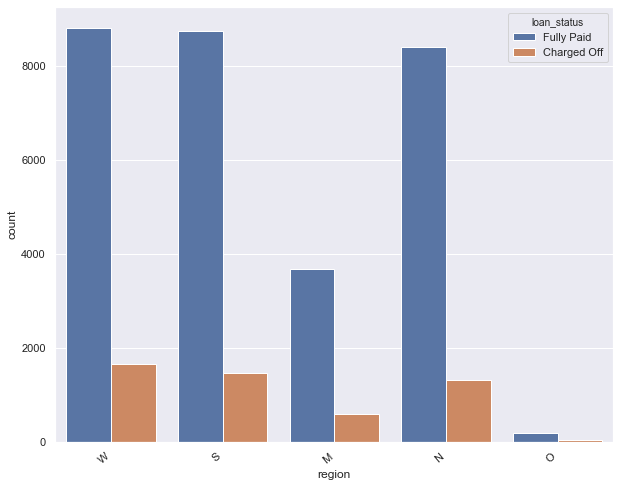

In [88]:
ax = sns.countplot(x=loan_df.region, hue = loan_df.loan_status ,data=loan_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

In [89]:
get_percentages_co_fp('region')

region  loan_status
M       Charged Off    13.897352
        Fully Paid     86.102648
N       Charged Off    13.476784
        Fully Paid     86.523216
O       Charged Off    17.647059
        Fully Paid     82.352941
S       Charged Off    14.310937
        Fully Paid     85.689063
W       Charged Off    15.888475
        Fully Paid     84.111525
Name: loan_amnt, dtype: float64

# Inference of 'region' on default

We see that others have the highest charged off percentage of loans at 17.6% followed by west at 15.8%

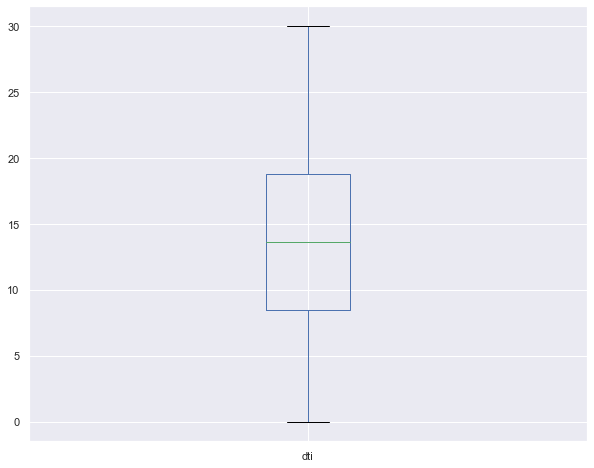

In [90]:
ax = loan_df.boxplot(column='dti', return_type='axes')

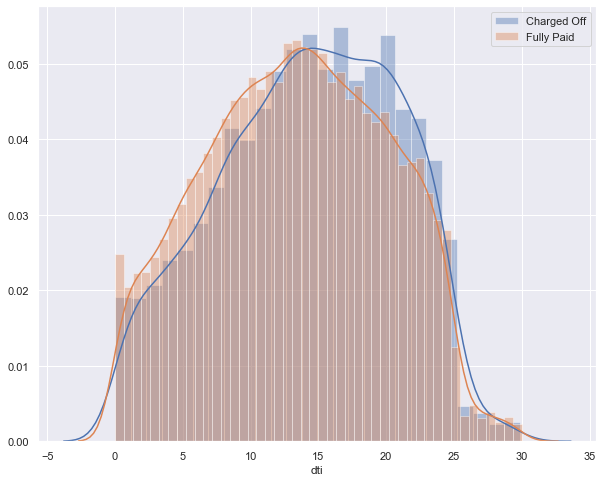

In [91]:
# When we plot the DTI for charged off and fully paid loans, we observe for higher dti's 14 and above the chances of loans being charged off consistently overtakes the chances of it being paid fully
sns.distplot(df_co.dti, label='Default loans')
sns.distplot(df_fp.dti, label='Paid loans')
plt.legend(labels=['Charged Off','Fully Paid'])
plt.show()

# Impact of 'DTI' on default
When we plot the DTI for charged off and fully paid loans, we observe for higher dti's 14 and above the chances of loans being charged off consistently overtakes the chances of it being paid fully


loan_status  Charged Off  Fully Paid  default_ratio
delinq_2yrs                                        
0                 4448.0     26647.0      14.304551
1                  459.0      2434.0      15.865883
2                  109.0       487.0      18.288591
3                   33.0       162.0      16.923077
4                   10.0        44.0      18.518519
5                    2.0        16.0      11.111111
6                    1.0         9.0      10.000000
7                    1.0         3.0      25.000000
8                    1.0         1.0      50.000000
9                    0.0         1.0       0.000000
11                   0.0         1.0       0.000000


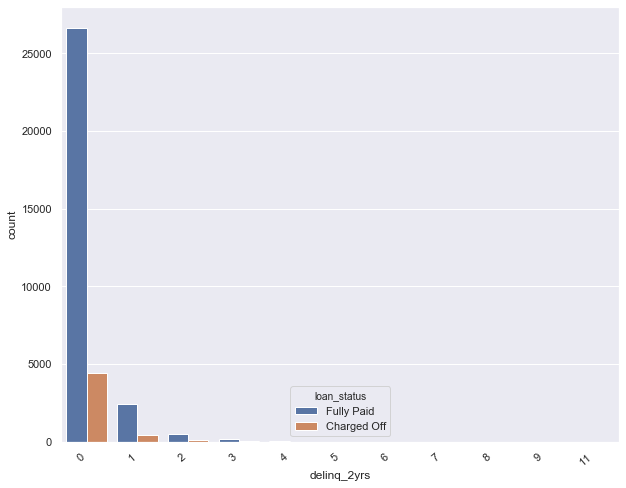

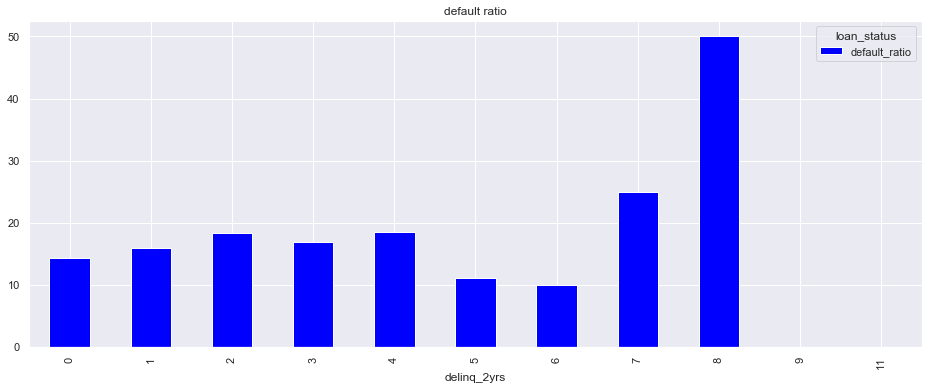

In [92]:
# This graph does not provide sufficient evidence for the loan being charged off
ax = sns.countplot(x=loan_df.delinq_2yrs, hue = loan_df.loan_status ,data=loan_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
draw_ratio_graph(loan_df, loan_df['delinq_2yrs'])

# Impact of 'delinq_2' on default

It seems that there is not much difference on default percentage as per delinq_2.
But the value 2 and 4 has the highest default ratio

In [93]:
# Extracting years from the cr_year column
loan_df['cr_year'] = loan_df['earliest_cr_line'].apply(lambda x: x.split('-')[1])

In [94]:
loan_df['cr_year'].unique()

array(['85', '99', '96', '04', '05', '07', '98', '89', '91', '93', '03',
       '01', '97', '83', '02', '84', '06', '81', '00', '94', '95', '92',
       '86', '90', '88', '80', '08', '79', '87', '78', '71', '72', '70',
       '69', '75', '82', '62', '73', '68', '74', '77', '76', '67', '63',
       '65', '66', '64', '59', '56', '46', '50', '61', '54'], dtype=object)

In [95]:
def year_convert(x) :
    
    if x in ['00','01','02','03','04','05','06','07','08','09','10','11','12']:
        return '20'+x
    else:
        return '19'+x

In [96]:
# Converting years so as to get a distribution
loan_df['cr_year'] = loan_df['cr_year'].apply(year_convert)

In [97]:
loan_df['cr_year'].unique()

array(['1985', '1999', '1996', '2004', '2005', '2007', '1998', '1989',
       '1991', '1993', '2003', '2001', '1997', '1983', '2002', '1984',
       '2006', '1981', '2000', '1994', '1995', '1992', '1986', '1990',
       '1988', '1980', '2008', '1979', '1987', '1978', '1971', '1972',
       '1970', '1969', '1975', '1982', '1962', '1973', '1968', '1974',
       '1977', '1976', '1967', '1963', '1965', '1966', '1964', '1959',
       '1956', '1946', '1950', '1961', '1954'], dtype=object)

In [98]:
loan_df['cr_year'] = loan_df['cr_year'].astype('int64')

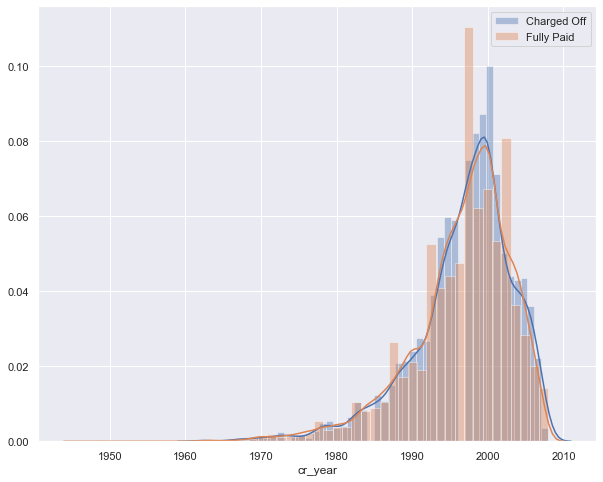

In [99]:
# cr_year does not seem to have much impact on loans being charged off
df_co = loan_df[loan_df.loan_status == 'Charged Off']
df_fp = loan_df[loan_df.loan_status == 'Fully Paid']
sns.distplot(df_co.cr_year, label='Default loans')
sns.distplot(df_fp.cr_year, label='Paid loans')
plt.legend(labels=['Charged Off','Fully Paid'])
plt.show()

[Text(0, 0, '0'),
 Text(0, 0, '1'),
 Text(0, 0, '2'),
 Text(0, 0, '3'),
 Text(0, 0, '4'),
 Text(0, 0, '5'),
 Text(0, 0, '6'),
 Text(0, 0, '7'),
 Text(0, 0, '8')]

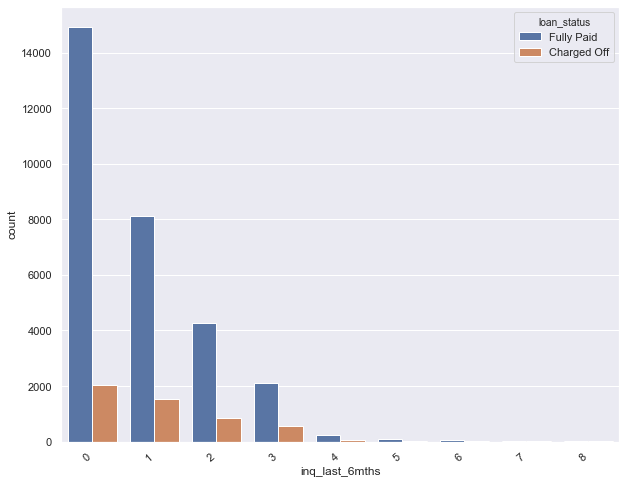

In [100]:
# inq_last_6mths also shows a consistent charged off to paid fully ratio, doesnt seem to impact much
ax = sns.countplot(x=loan_df.inq_last_6mths, hue = loan_df.loan_status ,data=loan_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

[Text(0, 0, '2'),
 Text(0, 0, '3'),
 Text(0, 0, '4'),
 Text(0, 0, '5'),
 Text(0, 0, '6'),
 Text(0, 0, '7'),
 Text(0, 0, '8'),
 Text(0, 0, '9'),
 Text(0, 0, '10'),
 Text(0, 0, '11'),
 Text(0, 0, '12'),
 Text(0, 0, '13'),
 Text(0, 0, '14'),
 Text(0, 0, '15'),
 Text(0, 0, '16'),
 Text(0, 0, '17'),
 Text(0, 0, '18'),
 Text(0, 0, '19'),
 Text(0, 0, '20'),
 Text(0, 0, '21'),
 Text(0, 0, '22'),
 Text(0, 0, '23'),
 Text(0, 0, '24'),
 Text(0, 0, '25'),
 Text(0, 0, '26'),
 Text(0, 0, '27'),
 Text(0, 0, '28'),
 Text(0, 0, '29'),
 Text(0, 0, '30'),
 Text(0, 0, '31'),
 Text(0, 0, '32'),
 Text(0, 0, '33'),
 Text(0, 0, '34'),
 Text(0, 0, '35'),
 Text(0, 0, '36'),
 Text(0, 0, '38'),
 Text(0, 0, '39'),
 Text(0, 0, '41'),
 Text(0, 0, '42'),
 Text(0, 0, '44')]

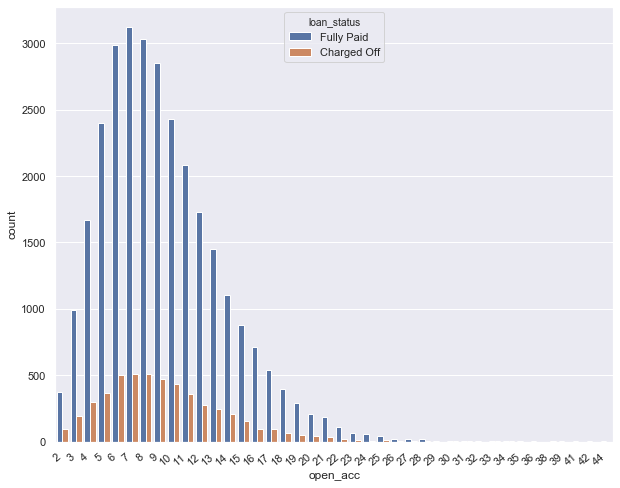

In [101]:
# open_acc also shows a consistent charged off to paid fully ratio, doesnt seem to impact much
ax = sns.countplot(x=loan_df.open_acc, hue = loan_df.loan_status ,data=loan_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

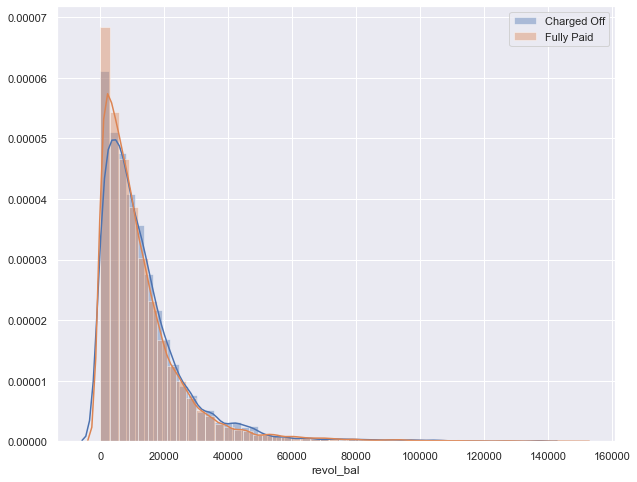

In [102]:
# revol_bal also doesnt seem to impact the charged off percentage
sns.distplot(df_co.revol_bal, label='Default loans')
sns.distplot(df_fp.revol_bal, label='Paid loans')
plt.legend(labels=['Charged Off','Fully Paid'])
plt.show()

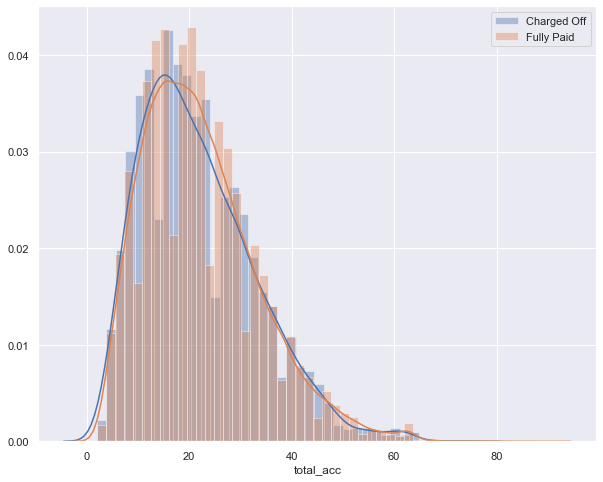

In [103]:
# total_acc also doesnt seem to impact the charged off percentage
sns.distplot(df_co.total_acc, label='Default loans')
sns.distplot(df_fp.total_acc, label='Paid loans')
plt.legend(labels=['Charged Off','Fully Paid'])
plt.show()

In [104]:
# Getting the loan issue year to see the trends
loan_df['issue_year'] = loan_df['issue_d'].apply(lambda x: x.split('-')[-1])
loan_df['issue_year'].unique()
loan_df['issue_year'] = loan_df['issue_year'].apply(year_convert)
loan_df['issue_year'] = loan_df['issue_year'].astype('int64')

[Text(0, 0, '2007'),
 Text(0, 0, '2008'),
 Text(0, 0, '2009'),
 Text(0, 0, '2010'),
 Text(0, 0, '2011')]

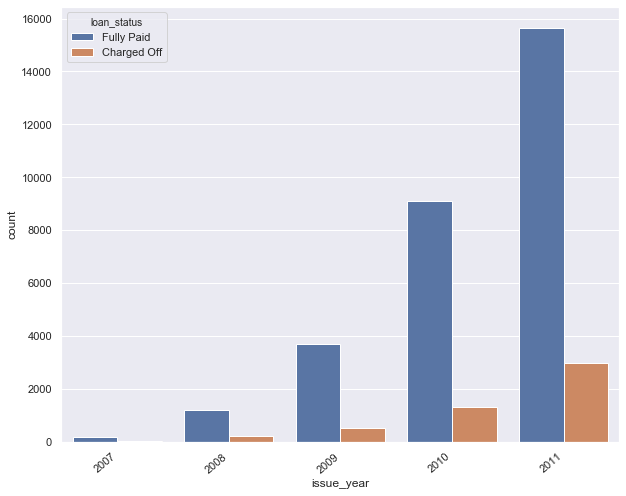

In [105]:
# We see that there is a exponential increase in the number of loans issued
ax = sns.countplot(x=loan_df.issue_year, hue = loan_df.loan_status ,data=loan_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

In [106]:
get_percentages_co_fp('issue_year')

issue_year  loan_status
2007        Charged Off    17.874396
            Fully Paid     82.125604
2008        Charged Off    15.886525
            Fully Paid     84.113475
2009        Charged Off    12.354755
            Fully Paid     87.645245
2010        Charged Off    12.537256
            Fully Paid     87.462744
2011        Charged Off    15.981539
            Fully Paid     84.018461
Name: loan_amnt, dtype: float64

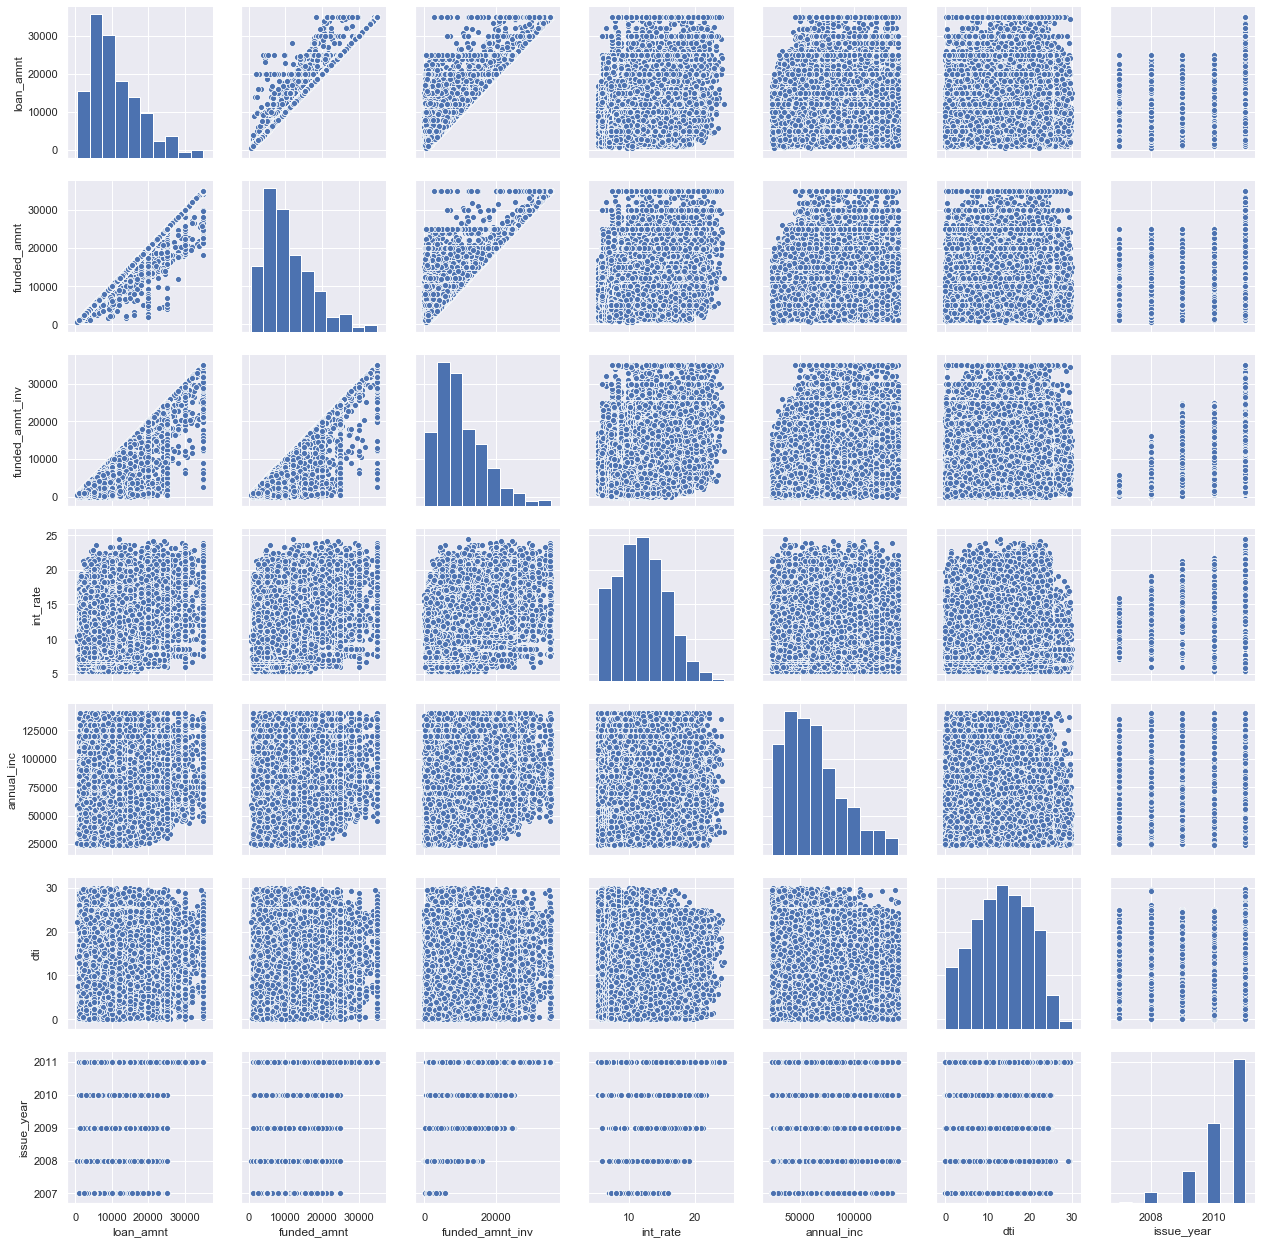

In [107]:
# Shows correlation between different columns
# We see that loan_amnt, funded_amnt and funded_amnt_inv have a high correlation among each other
sns.set()
cols = ['emp_length',
'loan_amnt',
'funded_amnt',
'funded_amnt_inv',
'term',
'int_rate',
'grade',
'sub_grade',
'home_ownership',
'annual_inc',
'verification_status',
'purpose',
'region',
'dti',
'issue_year']
sns.pairplot(loan_df[cols], height = 2.5)
plt.show();

# Bivariarate Analysis

## Taking term vs int_rate

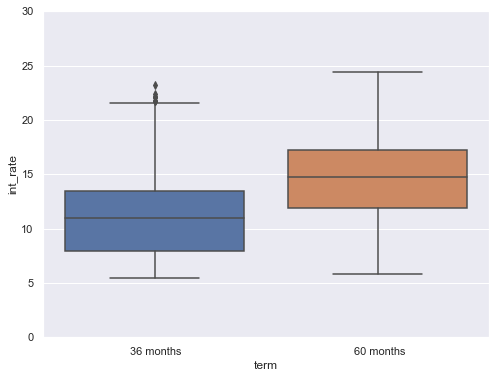

In [108]:
# Considering Term and Interest rates
# We see that interest rates is considerably larger for loans with a term of 60 months
# Since we see that loans tend to be charged off for higher rates on interest, could be the reason why term of 60 months have greated charge off percentage

var = 'term'
data = pd.concat([loan_df['int_rate'], loan_df[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="int_rate", data=data)
fig.axis(ymin=0, ymax=30);

## Taking term as 60 months and doing grade vs term plot

In [109]:
term60_df = loan_df[loan_df.term == ' 60 months']

[Text(0, 0, 'C'),
 Text(0, 0, 'F'),
 Text(0, 0, 'D'),
 Text(0, 0, 'E'),
 Text(0, 0, 'B'),
 Text(0, 0, 'G'),
 Text(0, 0, 'A')]

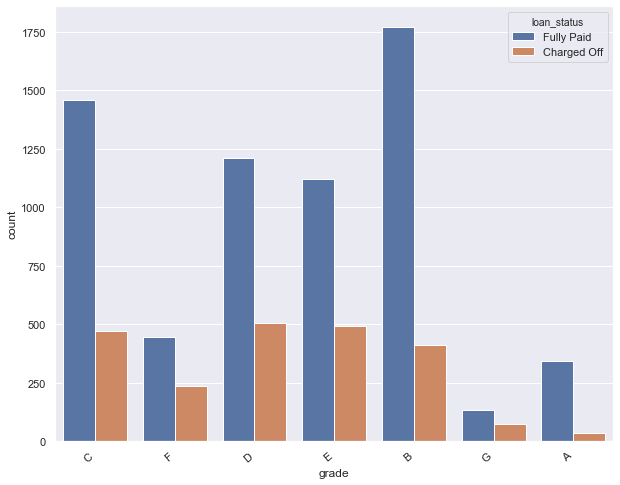

In [110]:
# For the 60 months term loans we observe the following
# For the same grade when the loan period is for 60 months the rate of being charged off is consistently higher
ax = sns.countplot(x=term60_df.grade,hue = loan_df.loan_status ,data=term60_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

In [111]:
temp_df = term60_df.groupby(['grade','loan_status'])['loan_amnt'].agg('count')
temp_df_percent = temp_df.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
temp_df_percent

grade  loan_status
A      Charged Off     8.823529
       Fully Paid     91.176471
B      Charged Off    18.835930
       Fully Paid     81.164070
C      Charged Off    24.455959
       Fully Paid     75.544041
D      Charged Off    29.346558
       Fully Paid     70.653442
E      Charged Off    30.440174
       Fully Paid     69.559826
F      Charged Off    34.699854
       Fully Paid     65.300146
G      Charged Off    35.922330
       Fully Paid     64.077670
Name: loan_amnt, dtype: float64

[Text(0, 0, '6.0'),
 Text(0, 0, '7.0'),
 Text(0, 0, '8.0'),
 Text(0, 0, '9.0'),
 Text(0, 0, '10.0'),
 Text(0, 0, '11.0'),
 Text(0, 0, '12.0'),
 Text(0, 0, '13.0'),
 Text(0, 0, '14.0'),
 Text(0, 0, '15.0'),
 Text(0, 0, '16.0'),
 Text(0, 0, '17.0'),
 Text(0, 0, '18.0'),
 Text(0, 0, '19.0'),
 Text(0, 0, '20.0'),
 Text(0, 0, '21.0'),
 Text(0, 0, '22.0'),
 Text(0, 0, '23.0'),
 Text(0, 0, '24.0')]

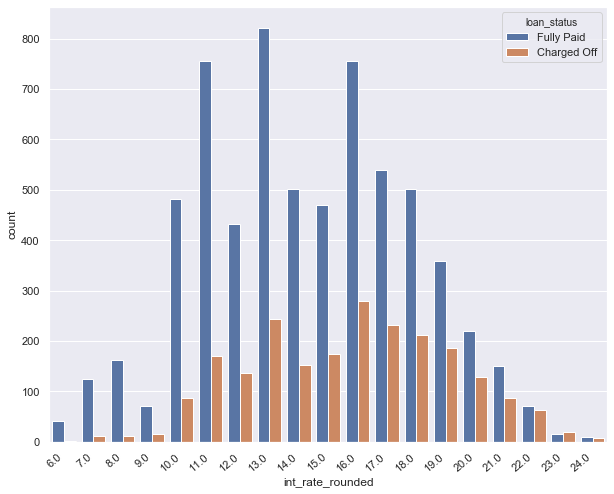

In [112]:
# From 9% to 19% interest there is a substantial difference between charged off loan % fore the entrire data set and for 60 months tenure loan
ax = sns.countplot(x=term60_df.int_rate_rounded,hue = loan_df.loan_status ,data=term60_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

## Purpose vs annual income

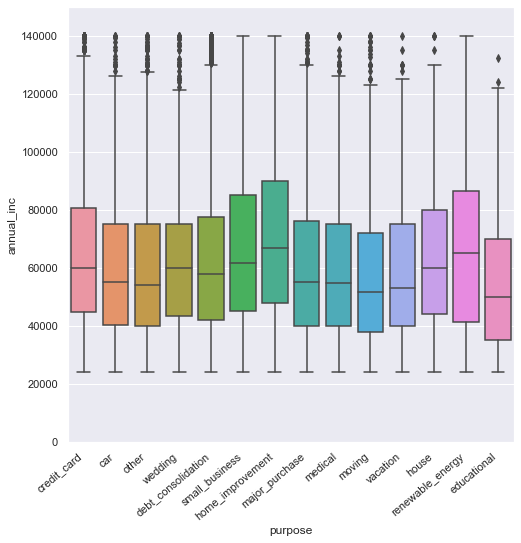

In [113]:
var = 'purpose'
data = pd.concat([loan_df['annual_inc'], loan_df[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 8))
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
fig = sns.boxplot(x=var, y="annual_inc", data=data)
fig.axis(ymin=0, ymax=150000);

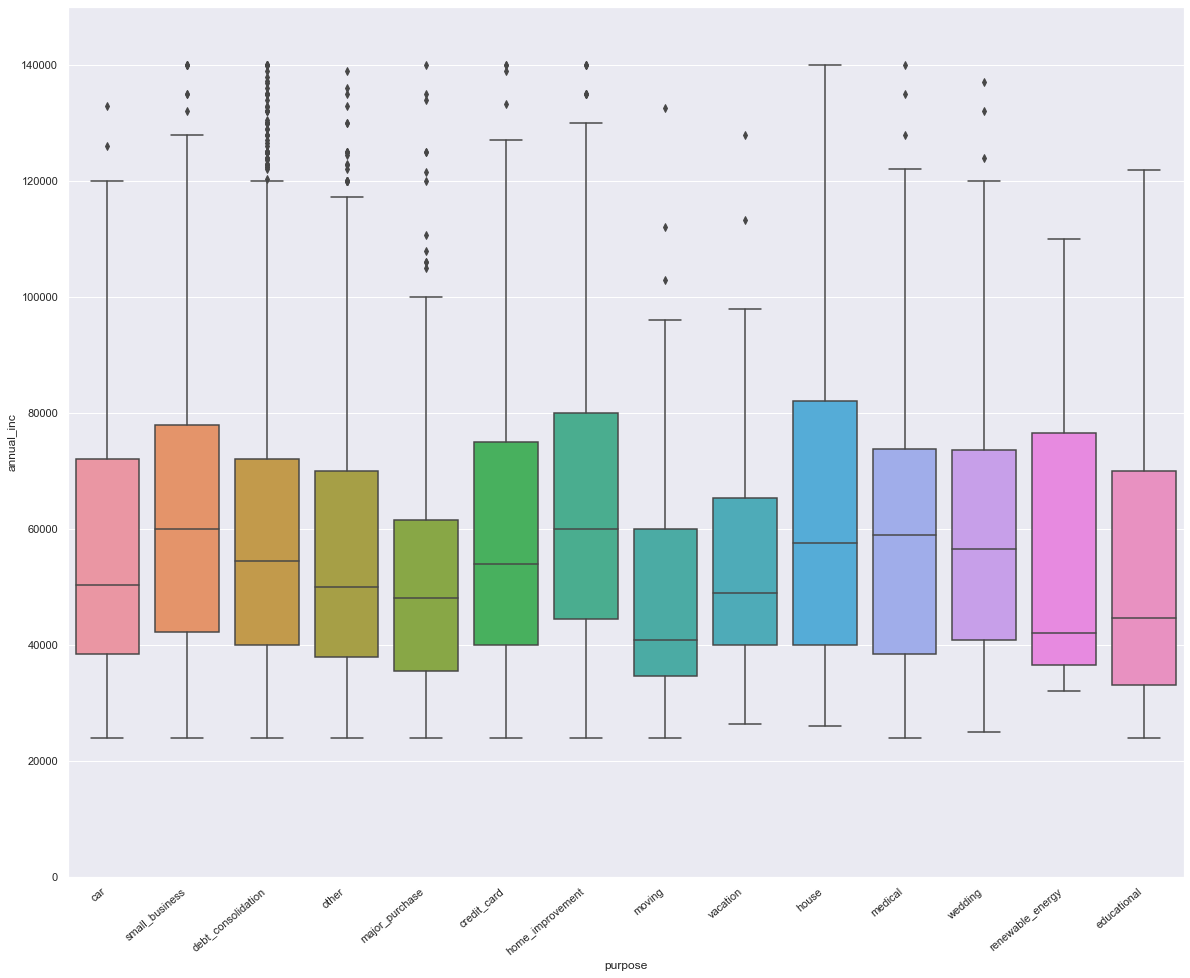

In [114]:
#For charged off loans

var = 'purpose'
data = pd.concat([df_co['annual_inc'], df_co[var]], axis=1)
f, ax = plt.subplots(figsize=(20, 16))
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
fig = sns.boxplot(x=var, y="annual_inc", data=data)
fig.axis(ymin=0, ymax=150000);

# Important information for bank:
The higher annual salary people go for:
home_improvement loan
credit card loan
small_business loan
house

The lower annual salary people go for:
educational loan

## Term vs purpose

In [115]:
loan_term_purpose = loan_df[["term","purpose"]]
loan_term_purpose = loan_term_purpose.groupby(["term","purpose"],as_index=False)
loan_term_purpose = pd.DataFrame(loan_term_purpose.size().reset_index(name = "count"))
loan_term_purpose.head()

,term,purpose,count
0,36 months,car,872
1,36 months,credit_card,3739
2,36 months,debt_consolidation,12043
3,36 months,educational,235
4,36 months,home_improvement,1797


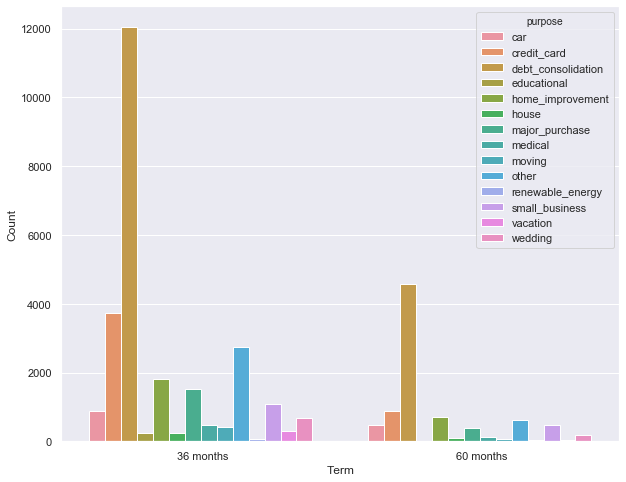

In [116]:
plt.figure(figsize=(10, 8))
ax = sns.barplot(x='term', y='count',hue='purpose',data=loan_term_purpose)
ax.set(xlabel='Term', ylabel='Count')
plt.show()

# Inference
Debt collection is the most reasoned purpose for loan


## Plot Grade against int_rate

In [117]:
loan_grade_interest = loan_df[["grade","int_rate"]]
loan_grade_interest = loan_grade_interest.groupby(["grade"], as_index=False).int_rate.mean()
loan_grade_interest

,grade,int_rate
0,A,7.322510
1,B,11.007393
2,C,13.533145
3,D,15.663942
4,E,17.612773
5,F,19.626569
6,G,21.248902


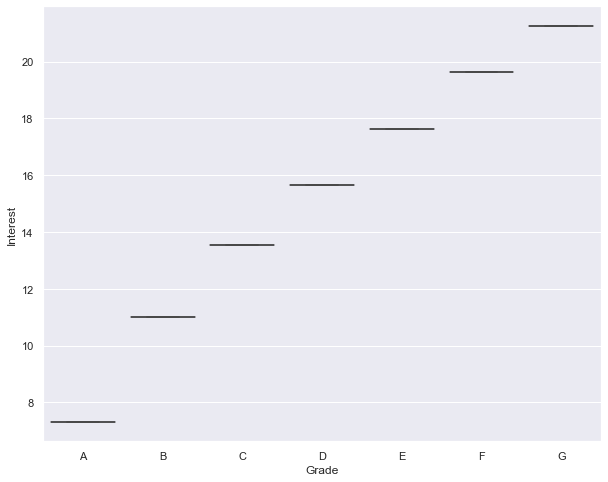

In [118]:
loan_grade_interest = loan_grade_interest.groupby(["grade","int_rate"], as_index=False)
loan_grade_interest = pd.DataFrame(loan_grade_interest.size().reset_index(name = "count"))
plt.figure(figsize=(10, 8))
ax = sns.boxplot(x='grade', y='int_rate',data=loan_grade_interest)
ax.set(xlabel='Grade', ylabel='Interest')
plt.show()

# Inference
The lower the grade, the higher is the interest

# Plot home ownership with purpose

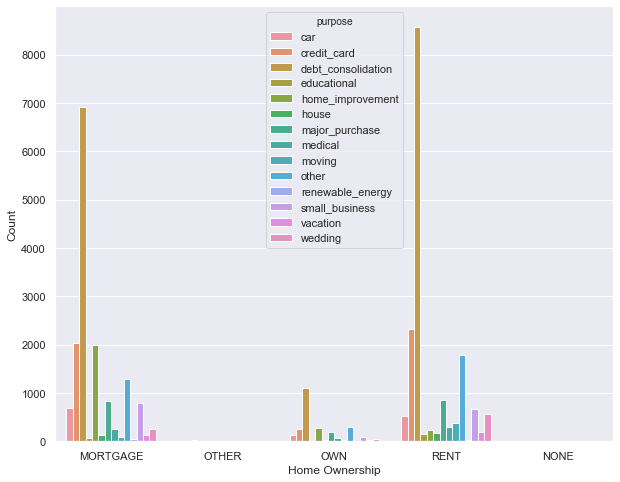

In [119]:
loan_purpose_home = loan_df[["home_ownership","purpose"]]
loan_purpose_home = loan_purpose_home.groupby(["purpose","home_ownership"],as_index=False)
loan_purpose_home = pd.DataFrame(loan_purpose_home.size().reset_index(name = "count"))
loan_purpose_home.head()
plt.figure(figsize=(10, 8))
ax = sns.barplot(x='home_ownership', y='count',hue='purpose',data=loan_purpose_home)
ax.set(xlabel='Home Ownership', ylabel='Count')

plt.show()

# Finding the derivations for the loan default

In [120]:
def count_graph(apply_filter):
    apply_filter = apply_filter.groupby(["loan_status"],as_index=False)
    print(apply_filter.size())
    apply_filter = pd.DataFrame(apply_filter.size().reset_index(name = "count"))
    print(apply_filter['count']/apply_filter['count'].sum())
    plt.figure(figsize=(10, 8))
    ax = sns.barplot(x='loan_status', y='count',data=apply_filter)
    plt.show()

# purpose: small business and term: 60 months

loan_status
Charged Off    190
Fully Paid     276
dtype: int64
0    0.407725
1    0.592275
Name: count, dtype: float64


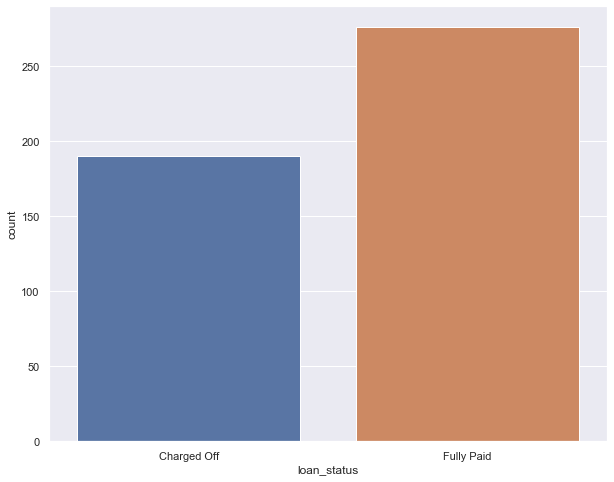

In [121]:
smallBusiness_Term60_filter = loan_df[loan_df['term'].str.contains("60 months") & loan_df['purpose'].str.contains('small_business') ]
count_graph(smallBusiness_Term60_filter)


# Above fig: 40 percent risk with the parameters: Term 60 months and small business

loan_status
Charged Off    6
Fully Paid     8
dtype: int64
0    0.428571
1    0.571429
Name: count, dtype: float64


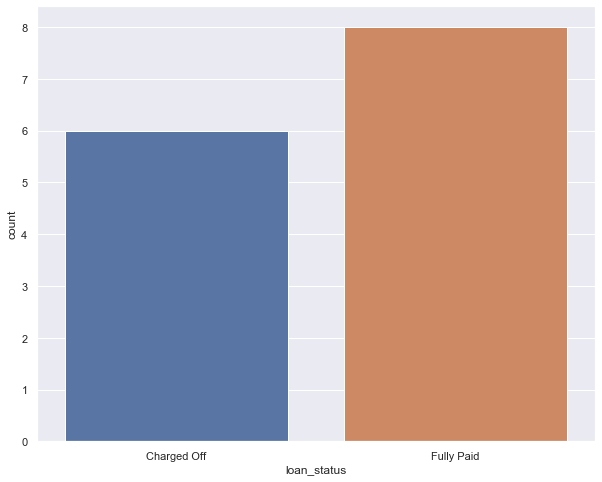

In [122]:
applied_filter = loan_df[loan_df['term'].str.contains("60 months") & loan_df['purpose'].str.contains('educational') ]
count_graph(applied_filter)


# Above fig: 42% risk with the parameter: Term 60 months and purpose: educational

loan_status
Charged Off    177
Fully Paid     232
dtype: int64
0    0.432763
1    0.567237
Name: count, dtype: float64


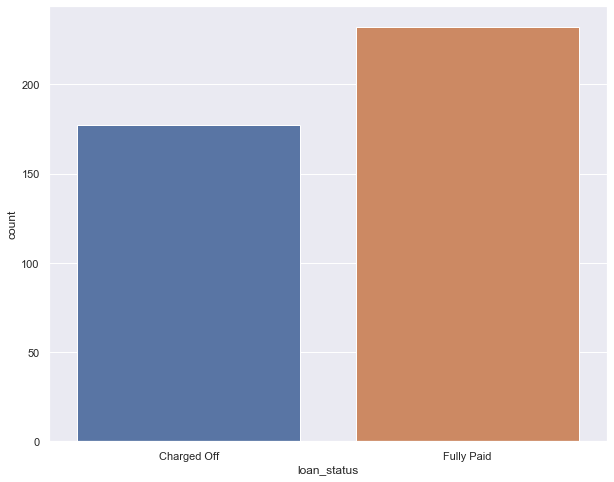

In [123]:
applied_filter = loan_df[loan_df['term'].str.contains("60 months") & loan_df['purpose'].str.contains('small_business') ]
applied_filter = applied_filter[applied_filter['annual_inc'] < 104000]

count_graph(applied_filter)


# Above fig: 43 percent risk with the parameters: Term 60 months and small business and annual income < 104000

loan_status
Charged Off    60
Fully Paid     58
dtype: int64
0    0.508475
1    0.491525
Name: count, dtype: float64


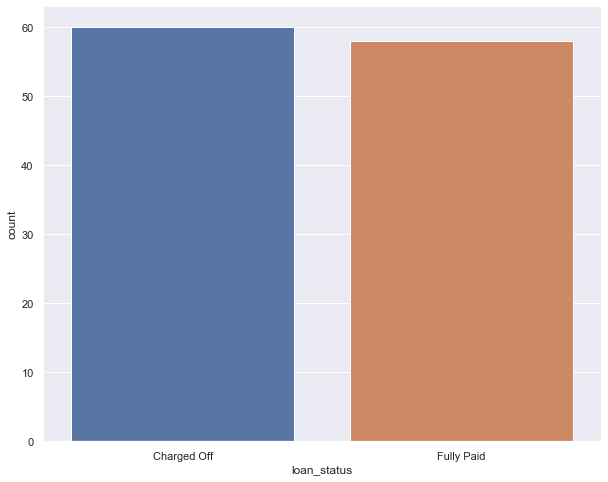

In [124]:
applied_filter = loan_df[loan_df['term'].str.contains("60 months") & loan_df['purpose'].str.contains('small_business') ]
applied_filter = applied_filter[applied_filter['annual_inc'] < 84000]
applied_filter = applied_filter[applied_filter['grade'].isin(['D', 'E'])]

count_graph(applied_filter)


# Above fig: 50 percent risk with the parameters: Term 60 months and small business and annual income < 84000 and grade in [D, E]

loan_status
Charged Off    2
dtype: int64
0    1.0
Name: count, dtype: float64


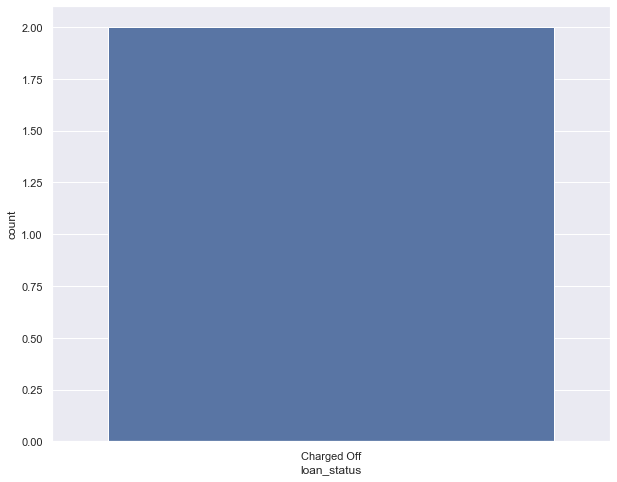

In [125]:
applied_filter = loan_df[loan_df['term'].str.contains("60 months") & loan_df['purpose'].str.contains('small_business') ]
applied_filter = applied_filter[applied_filter['annual_inc'] < 84000]
applied_filter = applied_filter[applied_filter['funded_amnt_inv'] > 30000]
applied_filter = applied_filter[applied_filter['grade'].isin(['D', 'E'])]

count_graph(applied_filter)


# Above fig: 100 percent risk with the parameters: Term 60 months and small business and annual income < 84000 and grade in [D, E] and funded amount greater than 30k

loan_status
Charged Off    7
Fully Paid     7
dtype: int64
0    0.5
1    0.5
Name: count, dtype: float64


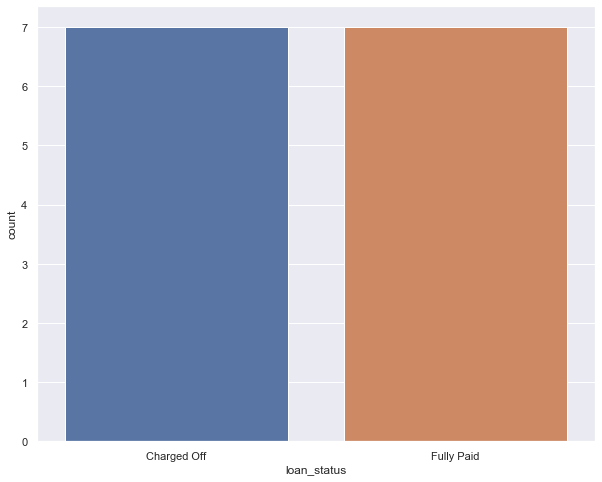

In [126]:
applied_filter = loan_df[loan_df['annual_inc'] < 60000]
applied_filter = applied_filter[applied_filter['funded_amnt_inv'] > 30000]
count_graph(applied_filter)


# Above fig: 50 percent risk with the parameters: annual income < 60000 and funded amount greater than 30k

# The summarised inference from univariarate analysis:

The below are general default trends. The permutation and combination of the below parameters and the values will give the majority of combinations for default.


Funded amount(inc) > 15k, 
Term = 60 months, 
Loan_rate > 16%, 
Grade in [’C’ , ‘D’ , ‘E’], 
Home ownership = RENTED, 
Annual income < 1 lac, 
Verification status = Verified, 
DTI > 14%, 
Delinq_2yrs >= 4 


# High correlation between following pair of columns
loan_amnt - installment
funded_amnt - installment
loan_amnt - int_rate
loan_amnt - funded_amnt